# Scoring
In this case we will fine tune the CNN model form pretrained `MobileNet` on `ImageNet` dataset.
We may able to create a CNN from scratch, but utilizing transfer learning and fine-tunning will be more beneficial in terms of time and perfromance.

## Import Libraries

In [1]:
import math
import glob
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

2025-04-24 07:48:28.509328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745480908.530167  174859 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745480908.536585  174859 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745480908.553301  174859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745480908.553318  174859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745480908.553321  174859 computation_placer.cc:177] computation placer alr

In [2]:
CLASS_NAMES = ['architecture', 'art and culture', 'food and drinks', 'travel and adventure']
CLASS_TO_INDEX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

IMAGE_SIZE = IMAGE_HEIGHT, IMAGE_WIDTH = 320, 380
IMAGE_SHAPE = IMAGE_SIZE + (3,)

# Model

## Load Validation Dataset

In [3]:
VAL_DIR = '../datasets/validation'

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    batch_size=16,
    image_size=IMAGE_SIZE,
    shuffle=True,
)

Found 115 files belonging to 4 classes.


I0000 00:00:1745480915.326191  174859 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


## Load Best Model

In [4]:
EXPERIMENT_BASE = 'http://127.0.0.1:5002'

# Setup tracking
mlflow.set_tracking_uri(uri=EXPERIMENT_BASE)

In [ ]:
BEST_MODEL_PATH = '../artifacts/best_acc/data/model.keras'

model = tf.keras.models.load_model('../artifacts/best_acc/data/model.keras')
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'val_loss, val_acc: {(val_loss, val_acc)}')

I0000 00:00:1745481025.988627  174963 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9532 - loss: 0.1867
val_loss, val_acc: (0.20025618374347687, 0.95652174949646)


In [ ]:
# Load form local
BEST_MODEL_PATH = '../artifacts/best_acc/data/model.keras'
model = tf.keras.models.load_model('../artifacts/best_acc/data/model.keras')

# OR, Load form mlflow
# BEST_MODEL_PATH = 'mlflow-artifacts:/696277914735305910/2d24cc4afb6b42ca8fe82afaca3813f0/artifacts/best_acc' # val_loss, val_acc: (0.20025616884231567, 0.95652174949646)
# model = mlflow.tensorflow.load_model(BEST_MODEL_PATH)

# Evaluate on val dataset
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'val_loss, val_acc: {(val_loss, val_acc)}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9518 - loss: 0.2331
val_loss, val_acc: (0.20025616884231567, 0.95652174949646)


## Load Test Dataset

In [6]:
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    return img_array

Total Test Images: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


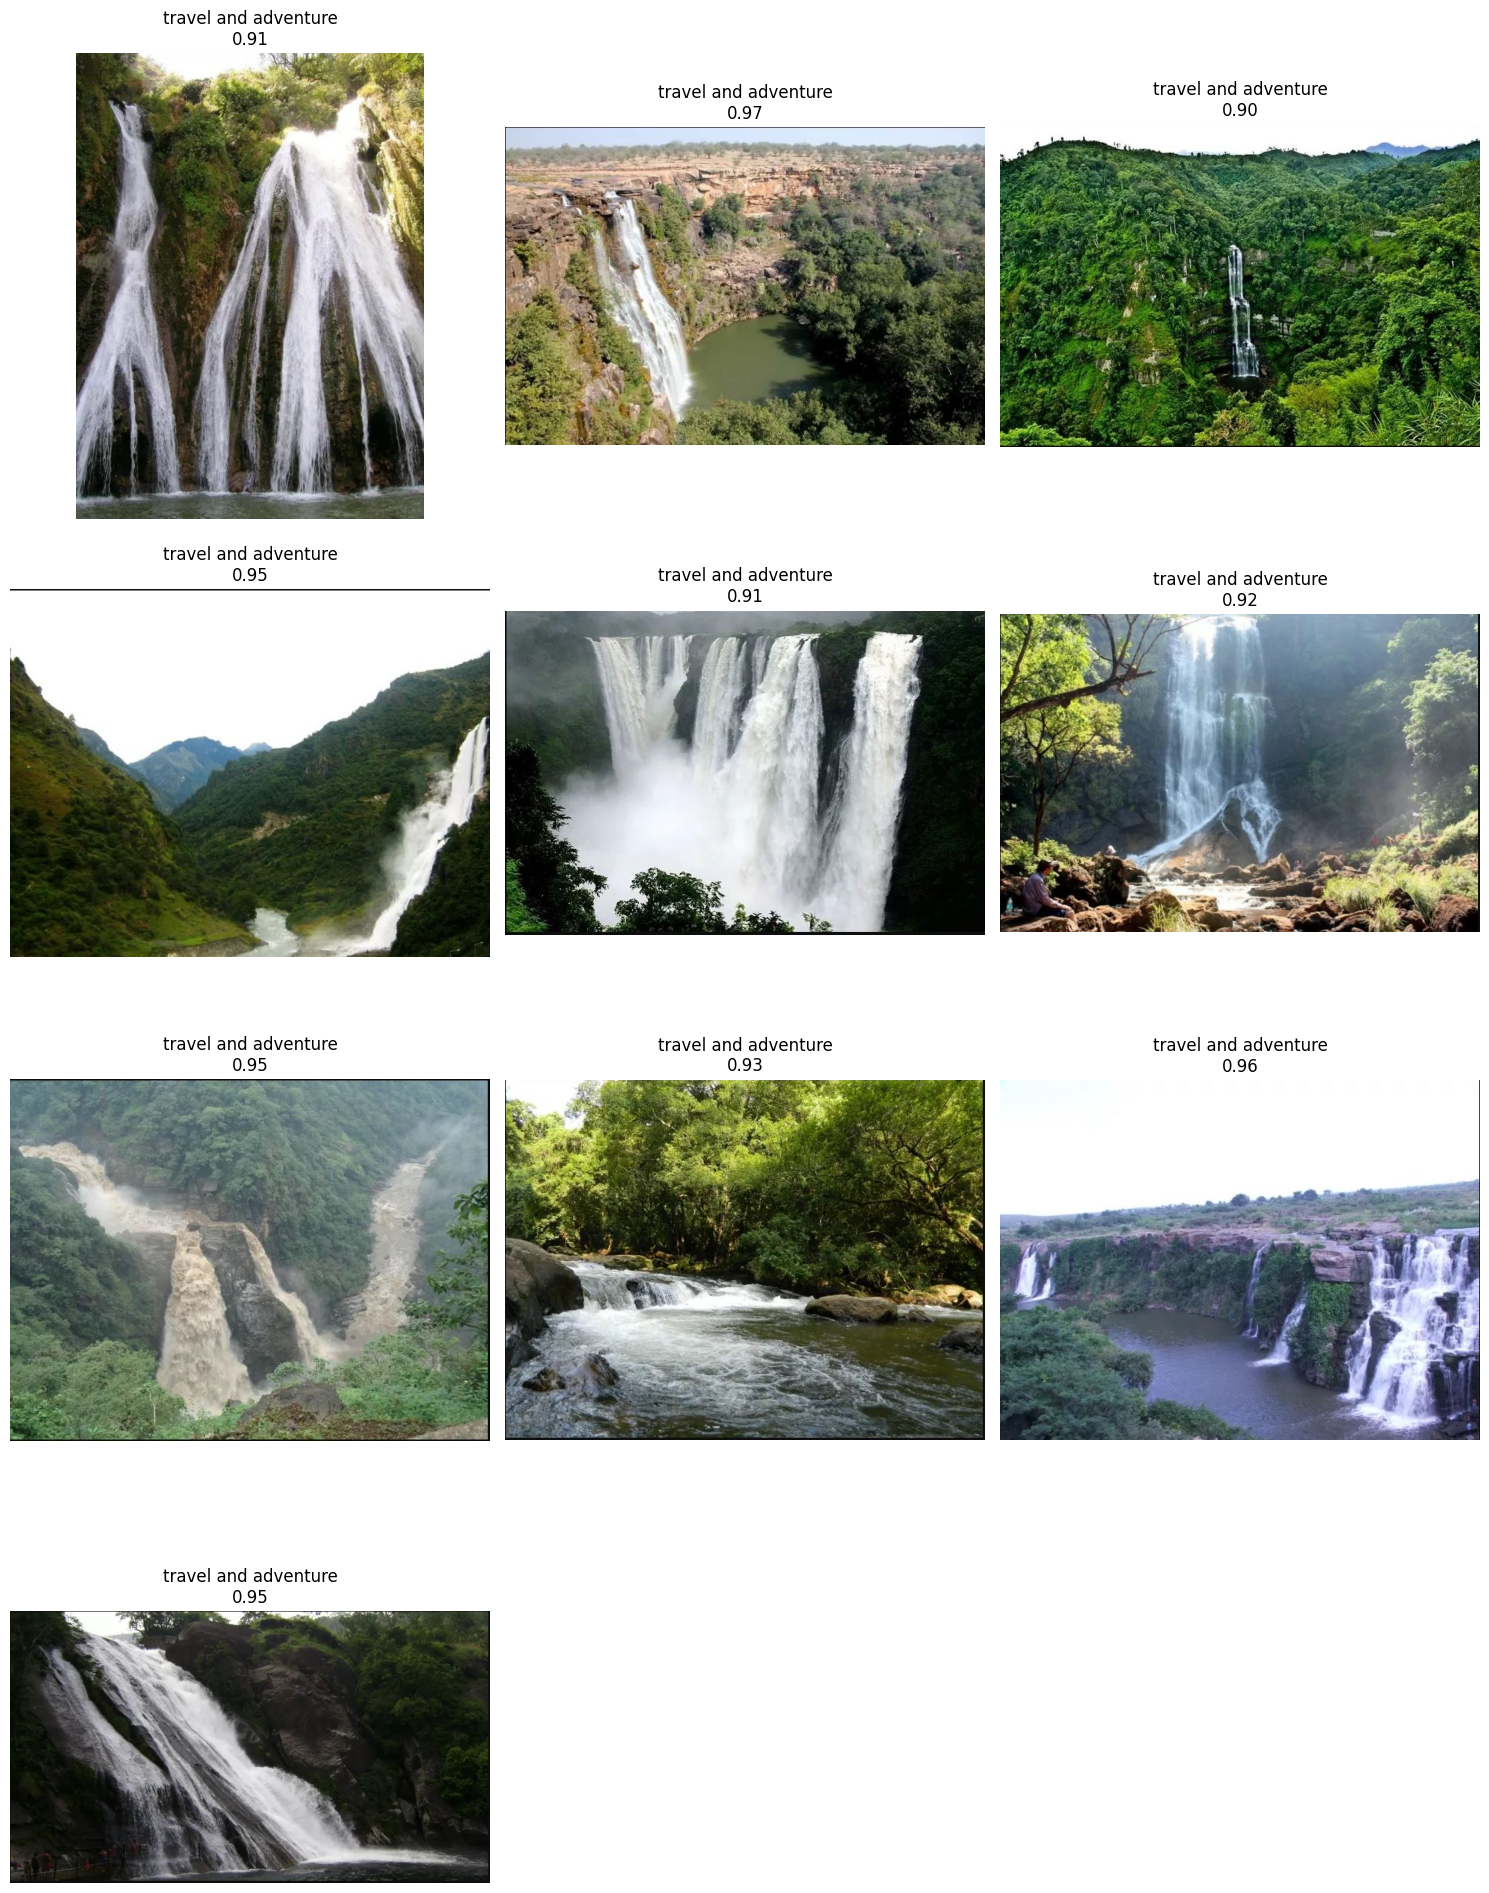

In [7]:
# Load image paths
image_paths = glob.glob('../datasets/test/classify/*')
print(f'Total Test Images: {len(image_paths)}')

# Grid setup
num_images = len(image_paths)
cols = 3
rows = math.ceil(num_images / cols)

# Plot
plt.figure(figsize=(5 * cols, 5 * rows))
for i, image_path in enumerate(image_paths):
    # Preprocess + Prediction
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)

    # Determine label
    predicted_score = np.max(prediction)
    predicted_class = CLASS_NAMES[np.argmax(prediction)]

    # Show image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(Image.open(image_path))
    plt.title(f'{predicted_class}\n{predicted_score:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()